In [15]:
import itertools
import random
import string
from collections.abc import Iterable

from pydantic import BaseModel

from intelligence_layer.core import Task, TaskSpan
from intelligence_layer.evaluation import (
    AggregationLogic,
    Aggregator,
    Example,
    InMemoryAggregationRepository,
    InMemoryDatasetRepository,
    InMemoryEvaluationRepository,
    InMemoryRunRepository,
    Runner,
    aggregation_overviews_to_pandas,
)
from intelligence_layer.evaluation.evaluation.evaluator.incremental_evaluator import (
    IncrementalEvaluationLogic,
    IncrementalEvaluator,
)
from intelligence_layer.evaluation.run.domain import SuccessfulExampleOutput


class DummyTask(Task[str, str]):
    def __init__(self, model: str, prompt: str):
        self.model = model
        self.prompt = prompt

    def do_run(self, input: str, task_span: TaskSpan) -> str:
        wordlist = [
            "apple",
            "banana",
            "car",
            "dog",
            "elephant",
            "fish",
            "goat",
            "hat",
            "igloo",
            "jacket",
        ]
        sentences = [
            "Once upon a time,",
            "In a land far, far away,",
            "Suddenly,",
            "One day,",
            "In the morning,",
        ]

        random.seed(hash(input) + hash(self.model))  # Set the seed based on the prompt

        story = self.prompt + " "
        for _ in range(10):
            sentence = random.choice(sentences)
            word = random.choice(wordlist)
            story += sentence + " " + word + " "
        return story


class DummyEvaluation(BaseModel):
    text_length: int
    normalized_capital_count: float


class DummyIncrementalEvaluationLogic(
    IncrementalEvaluationLogic[str, str, str, DummyEvaluation]
):
    def do_incremental_evaluate(
        self,
        example: Example[str, str],
        outputs: list[SuccessfulExampleOutput[str]],
        already_evaluated_outputs: list[list[SuccessfulExampleOutput[str]]],
    ) -> DummyEvaluation:
        return DummyEvaluation(
            text_length=len(outputs[0].output),
            normalized_capital_count=sum(c.isupper() for c in outputs[0].output)
            / len(outputs[0].output),
        )

class DummyAggregatedEvaluation(BaseModel):
    avg_length: float
    avg_normalized_capital_count: float


class DummyAggregationLogic(
    AggregationLogic[DummyEvaluation, DummyAggregatedEvaluation]
):
    def aggregate(
        self, evaluations: Iterable[DummyEvaluation]
    ) -> DummyAggregatedEvaluation:
        eval_list = list(evaluations)
        avg_length = sum([s.text_length for s in eval_list]) / len(eval_list)
        avg_normalized_capital_count = sum(
            [s.normalized_capital_count for s in eval_list]
        ) / len(eval_list)
        return DummyAggregatedEvaluation(
            avg_length=avg_length,
            avg_normalized_capital_count=avg_normalized_capital_count,
        )


# Initialize the dataset
random.seed(42)
examples = [
    Example(
        input="".join(random.choices(string.ascii_letters, k=random.randint(1, 50))),
        expected_output=None,
    )
    for i in range(10)
]

dataset_repository = InMemoryDatasetRepository()
dataset = dataset_repository.create_dataset(
    examples=examples, dataset_name="my-dataset"
)

# Optimizing Tasks by Comparing Aggregations

In this tutorial we demonstrate how to optimize a given `Task` that depends on a `model` and a `prompt` parameter. This is done by evaluating each combination of parameters for the tasks separately and then comparing the resulting aggregations.

In this scenario, our task does not depend on an LLM, for the sake of execution speed. However, the demonstrated principles generalize to other use cases.

## Setup

We assume the dataset, the `Task` and `DatasetRepository` are already given, so we can start by instantiating the remaining repositories and our `Evaluator`. The `EXPERIMENT_NAME` will later be used to identify the aggregations of interest. Therefore, we pass it to the `Evaluator` and later to the `Runner` and `Aggregator`. 

In [16]:
EXPERIMENT_NAME = "compare-tasks"

# The `DatasetRepository` is named `dataset_repository`
run_repository = InMemoryRunRepository()
evaluation_repository = InMemoryEvaluationRepository()
aggregation_repository = InMemoryAggregationRepository()

incremental_evaluator = IncrementalEvaluator(
    dataset_repository,
    run_repository,
    evaluation_repository,
    "My incremental evaluation",
    DummyIncrementalEvaluationLogic(),
)

aggregator = Aggregator(
    evaluation_repository,
    aggregation_repository,
    EXPERIMENT_NAME,
    DummyAggregationLogic(),
)

## Running Experiments for Different Configurations

In [17]:
# Definition of parameters
model_list = ["model a", "model b", "model c"]
label = "dummy_label"
labels = {label}

prompt_list = [
    "A nice story starts with:",
    "Some kind of prompt",
    "No prompt at all",
    "OPTIMIZING PROMPTS IS HARD TO DO",
]

# Loop over all combinations of parameters and run the `Task` for each combination.
# Note, that this can be **very** expensive for large sets of parameters.
for i, (model, prompt) in enumerate(itertools.product(model_list, prompt_list)):
    dummy_task = DummyTask(model=model, prompt=prompt)

    # Model and prompt are stored in the metadata to specify the configuration of the current experiment
    metadata = dict({"model": model, "prompt": prompt})
    description = f"Evaluate dummy task {i}"
    runner = Runner(dummy_task, dataset_repository, run_repository, EXPERIMENT_NAME)
    run_overview = runner.run_dataset(
        dataset.id, metadata=metadata, description=description, labels=labels
    )

    eval_overview = incremental_evaluator.evaluate_runs(
        run_overview.id, metadata=metadata, description=description, labels=labels
    )

    aggregator.aggregate_evaluation(
        eval_overview.id, metadata=metadata, description=description, labels=labels
    )

Evaluating: 10it [00:00, 52363.35it/s]
Evaluating: 10it [00:00, 238312.73it/s]
Evaluating: 10it [00:00, 217321.45it/s]
Evaluating: 10it [00:00, 33235.37it/s]
Evaluating: 10it [00:00, 79437.58it/s]
Evaluating: 10it [00:00, 62137.84it/s]
Evaluating: 10it [00:00, 71943.46it/s]
Evaluating: 10it [00:00, 272357.40it/s]
Evaluating: 10it [00:00, 126716.13it/s]
Evaluating: 10it [00:00, 68089.35it/s]
Evaluating: 10it [00:00, 83220.32it/s]
Evaluating: 10it [00:00, 207638.81it/s]


## Comparison of Different Configurations



In [18]:
# Retrieve all aggregations and filter them by desired criteria, i.e., the label `dummy_label`. Filtering can also be done on description and/or metadata.
aggregations_of_interest = [
    overview
    for overview in aggregation_repository.aggregation_overviews(
        aggregation_type=DummyAggregatedEvaluation
    )
    if label in overview.labels
]

# Convert the desired aggregation into a pandas dataframe
formated_aggregations = aggregation_overviews_to_pandas(aggregations_of_interest)

# Print all columns to check for columns of interest
formated_aggregations.columns

Index(['evaluation_overviews', 'id', 'start', 'end',
       'successful_evaluation_count', 'crashed_during_evaluation_count',
       'description', 'labels', 'avg_length', 'avg_normalized_capital_count',
       'model', 'prompt'],
      dtype='object')

 The following steps are very specific to the experiment setup, mostly depending on standard pandas knowledge. They are just one example of how one might analyze the configurations.

In [19]:
aggregation_fields = list(DummyAggregatedEvaluation.model_fields.keys())
# Filter for columns of interest
formated_aggregations = formated_aggregations[["model", "prompt", *aggregation_fields]]

display(
    formated_aggregations.sort_values(
        by="avg_normalized_capital_count", ascending=False
    )
)

,model,prompt,avg_length,avg_normalized_capital_count
1,model c,OPTIMIZING PROMPTS IS HARD TO DO,243.2,0.152765
11,model a,OPTIMIZING PROMPTS IS HARD TO DO,245.5,0.151416
0,model b,OPTIMIZING PROMPTS IS HARD TO DO,247.7,0.150795
6,model c,No prompt at all,227.2,0.048644
2,model a,No prompt at all,229.5,0.048185
9,model c,Some kind of prompt,230.2,0.048004
10,model b,No prompt at all,231.7,0.047990
5,model a,Some kind of prompt,232.5,0.047557
8,model b,Some kind of prompt,234.7,0.047364
3,model c,A nice story starts with:,236.2,0.046774


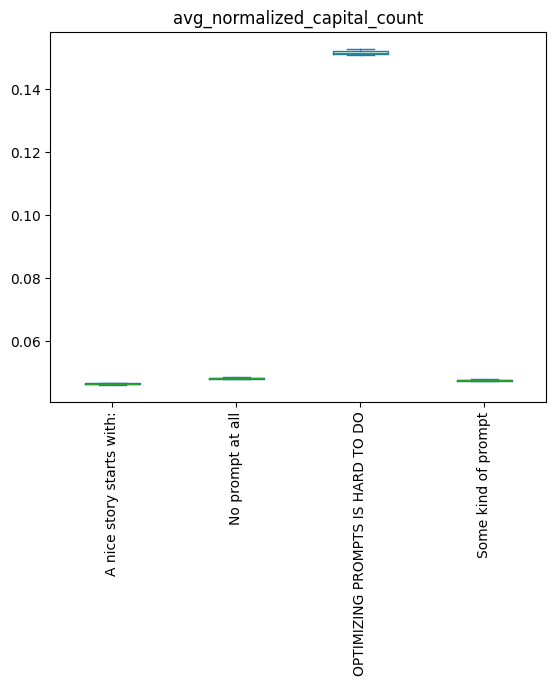

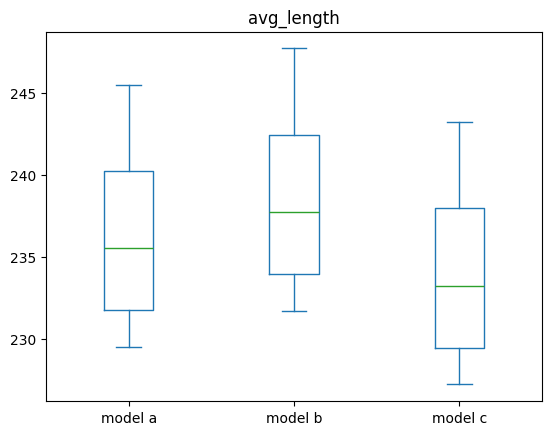

In [20]:
formated_aggregations.pivot(
    index="model", columns="prompt", values="avg_normalized_capital_count"
).plot(kind="box", rot=90, title="avg_normalized_capital_count")
formated_aggregations.pivot(index="prompt", columns="model", values="avg_length").plot(
    kind="box", title="avg_length"
)
pass

With these results, it's easy to see which prompt is best to optimize our score! The model on the other hand does not seem to have a big impact on our metrics.

In [21]:
from intelligence_layer.evaluation.evaluation.evaluator.incremental_evaluator import (
    IncrementalEvaluationLogic,
    IncrementalEvaluator,
)
from intelligence_layer.evaluation.run.domain import SuccessfulExampleOutput

model_list.append("model d")


# Step 3
# Loop over all combinations of parameters and run the `Task` for each combination.
# Note, that this can be **very** expensive for large sets of parameters.
for i, (model, prompt) in enumerate(itertools.product(model_list, prompt_list)):
    dummy_task = DummyTask(model=model, prompt=prompt)

    # Model and prompt are stored in the metadata to specify the configuration of the current experiment
    metadata = dict({"model": model, "prompt": prompt})
    description = f"Evaluate dummy task {i}"
    runner = Runner(dummy_task, dataset_repository, run_repository, EXPERIMENT_NAME)
    run_overview = runner.run_dataset(
        dataset.id,
        metadata=metadata,
        description=description,
        labels=labels,
        recompute_if_metadata_changed=True,
    )

    incremental_evaluator.evaluate_additional_runs(
        *run_repository.run_overview_ids(),
        previous_evaluation_ids=evaluation_repository.evaluation_overview_ids(),
    )

    aggregator.aggregate_evaluation(
        eval_overview.id, metadata=metadata, description=description, labels=labels
    )

print(len(list(run_repository.run_overviews())))
print(len(list(evaluation_repository.evaluation_overviews())))

Evaluating: 10it [00:00, 174762.67it/s]
Evaluating: 10it [00:00, 226719.14it/s]
Evaluating: 10it [00:00, 182361.04it/s]
Evaluating: 10it [00:00, 184771.10it/s]
Evaluating: 10it [00:00, 147168.56it/s]
Evaluating: 10it [00:00, 233016.89it/s]
Evaluating: 10it [00:00, 202623.38it/s]
Evaluating: 10it [00:00, 196915.68it/s]
Evaluating: 10it [00:00, 158875.15it/s]
Evaluating: 10it [00:00, 236966.33it/s]
Evaluating: 10it [00:00, 54330.36it/s]
Evaluating: 10it [00:00, 251155.93it/s]
Evaluating: 10it [00:00, 213995.10it/s]
Evaluating: 10it [00:00, 128266.18it/s]
Evaluating: 10it [00:00, 116185.71it/s]
Evaluating: 10it [00:00, 123000.12it/s]

16
28
